# Error Mining

Le but de ce notebook est de trouver les erreurs les plus fréquentes du parseur afin de corriger le treebank en ayant le plus d'impact possible. Nous regarderons donc quelles sont les types d'erreurs faites par le parseur, quelles sont les plus problématiques et quelle distribution ont ces erreurs.

In [1]:
PATH_TREEBANK = "../data/sud_naija-NSC.with_prediction.conllu"

In [2]:
# le fichier est t-il bien présent ?
try:
    with open(PATH_TREEBANK, "r") as f:
        print("Le fichier est présent au chemin : {}".format(PATH_TREEBANK))
        pass
except FileNotFoundError:
    print("Le fichier n'est PAS , revoyez le chemin : {}".format(PATH_TREEBANK))
    exit()

Le fichier est présent au chemin : ../data/sud_naija-NSC.with_prediction.conllu


In [3]:
# On peut commencer à parser le fichier avec la librairie conllup
from conllup.conllup import readConlluFile 
sentences = readConlluFile(PATH_TREEBANK)

if len(sentences) == 0:
    raise ValueError("Le fichier est vide !")
else :
    print("Le fichier contient {} phrases".format(len(sentences)))

Le fichier contient 8259 phrases


## Influence de la taille de la phrase

In [16]:
# On récupère les nombres de réussite et d'échec pour chaque longueur de phrase
results_per_length = {}
def get_default_result():
    return {
            "total_token": 0,
            "success_upos": 0, 
            "success_deprel": 0, 
            "success_head": 0, 
            "success_head_and_deprel": 0, 
        }

for sentence in sentences:
    tokens = sentence["treeJson"]["nodesJson"].values()
    length = len(tokens)
    if length not in results_per_length:
        results_per_length[length] = get_default_result()
    
    for token in tokens:
        head_token_ID = str(token['HEAD'])
        deprel = token['DEPREL']
        upos = token['UPOS']

        head_pred = token['MISC']['head_pred']
        deprel_pred = token['MISC']['deprel_pred']
        upos_pred = token['MISC']['upos_pred']

        if head_token_ID == head_pred:
            results_per_length[length]["success_head"] += 1

        if deprel == deprel_pred:
            results_per_length[length]["success_deprel"] += 1
        
        if head_token_ID == head_pred and deprel == deprel_pred:
            results_per_length[length]["success_head_and_deprel"] += 1

        if upos == upos_pred:
            results_per_length[length]["success_upos"] += 1

        results_per_length[length]["total_token"] += 1

# On affiche les résultats
import json
print(json.dumps(results_per_length, indent=4))

{
    "11": {
        "total_token": 4301,
        "success_upos": 4187,
        "success_deprel": 4077,
        "success_head": 4150,
        "success_head_and_deprel": 3999
    },
    "10": {
        "total_token": 4070,
        "success_upos": 3968,
        "success_deprel": 3821,
        "success_head": 3906,
        "success_head_and_deprel": 3737
    },
    "18": {
        "total_token": 4248,
        "success_upos": 4126,
        "success_deprel": 3999,
        "success_head": 4005,
        "success_head_and_deprel": 3843
    },
    "12": {
        "total_token": 3996,
        "success_upos": 3890,
        "success_deprel": 3787,
        "success_head": 3874,
        "success_head_and_deprel": 3721
    },
    "9": {
        "total_token": 4068,
        "success_upos": 3941,
        "success_deprel": 3872,
        "success_head": 3943,
        "success_head_and_deprel": 3800
    },
    "39": {
        "total_token": 1950,
        "success_upos": 1911,
        "success_deprel": 18

In [21]:
# Nous utilisons matplotlib pour faire faire nos graphiques
import matplotlib as mpl
import matplotlib.pyplot as plt

# Voici des paramètres pour que les graphiques soient plus lisibles, changez les à votre convenance
params = {
   'axes.labelsize': 8,
 #  'text.fontsize': 8,
   'legend.fontsize': 10,
   'xtick.labelsize': 10,
   'ytick.labelsize': 10,
   'text.usetex': False,
   'figure.figsize': [10, 5]
   }
mpl.rcParams.update(params)
plt.style.use('seaborn-v0_8-darkgrid') # pour avoir un fond gris quadrillé

[0.043478260869565216, 0.049679487179487176, 0.046612466124661245, 0.052422270426608825, 0.04591836734693878, 0.055491990846681924, 0.048180924287118974, 0.06117936117936118, 0.05208091141594978, 0.0523023023023023, 0.05325443786982249, 0.05511463844797178, 0.04801864801864802, 0.058173076923076925, 0.06225848003434951, 0.05861581920903955, 0.060863058119231726, 0.054787234042553194, 0.05836236933797909, 0.058823529411764705, 0.06677018633540373, 0.05032051282051282, 0.05785714285714286, 0.05078416728902166, 0.0682643427741467, 0.06746031746031746, 0.06422413793103449, 0.05992063492063492, 0.057408419901585565, 0.05129716981132076, 0.06958473625140292, 0.06042780748663101, 0.07883597883597884, 0.07249322493224933, 0.05645645645645646, 0.05832147937411095, 0.06358974358974359, 0.0659090909090909, 0.06794425087108014, 0.07644110275689223, 0.07054263565891473, 0.06818181818181818, 0.06262626262626263, 0.05298913043478261, 0.05646481178396072, 0.06740196078431372, 0.09329446064139942, 0.06

(4.0, 80.0)

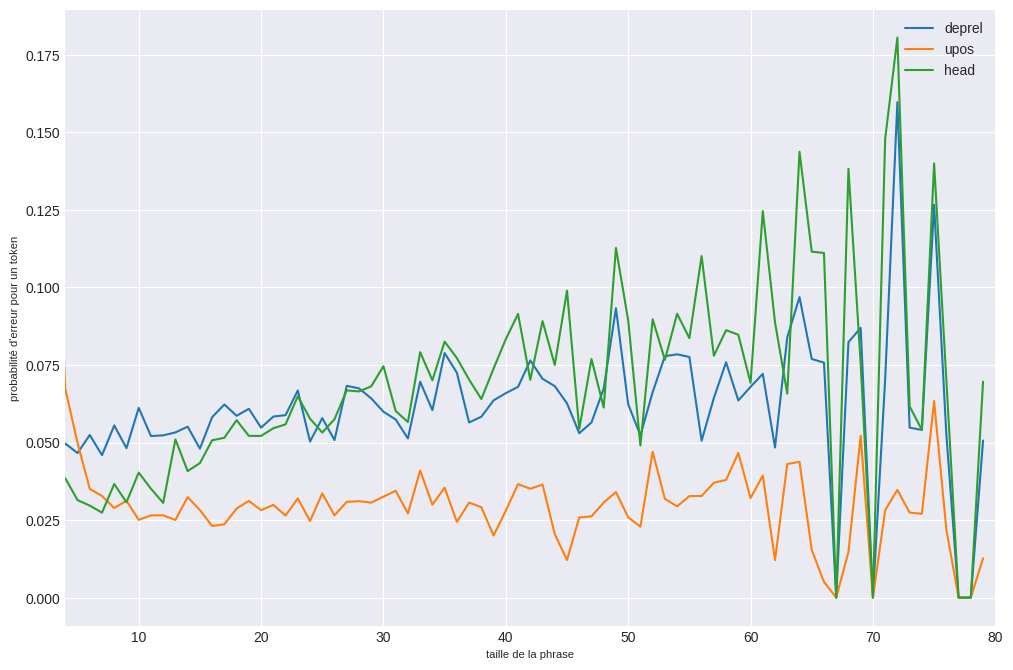

In [23]:
# Essayons de mettre tout ça dans un graphique
# On va plotter les ratio d'echec (1 - ratio_reussite) ça sera plus visuel
# Dans un même graphique on va plotter les 3 ratios : upos, deprel, head


x_lim = [3, 80] # on ne prend pas en compte les phrases de moins de 3 tokens et de plus de 80 tokens

plt.figure(figsize=(12,8))

for label in ["deprel", "upos", "head"]:
    y = []
    for length in range(x_lim[0], x_lim[1]):
        number_success = results_per_length.get(length, get_default_result())["success_{}".format(label)]
        number_total = results_per_length.get(length, get_default_result())["total_token"]
        
        fail_ratio = 0
        if number_total != 0:
            fail_ratio = (number_total - number_success) / number_total
        
        y.append(fail_ratio)

    print(y)
    plt.plot(range(x_lim[0], x_lim[1]), y, label=label)

plt.xlabel("taille de la phrase")
plt.ylabel("probabilité d'erreur pour un token")
plt.legend()
plt.xlim([x_lim[0]+1,x_lim[1]])
